In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras.applications.inception_v3 import ResNet101V2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import cv2
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from keras.applications import DenseNet121
from matplotlib import pyplot as plt
from keras.utils import to_categorical

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [2]:
gc.collect()
train_df = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/train.csv')
train_df = train_df.sample(frac = 1)
train_x_images = np.array(train_df['image_id'])
train_y = []
for i,j in train_df.iterrows():
    train_y.append(list(j)[1:])
train_y = np.array(train_y)
file_name = np.array(train_df['image_id'])
train_X = []
gc.collect()
for i in file_name:
    image = (cv2.imread("/kaggle/input/plant-pathology-2020-fgvc7/images/" + i + ".jpg"))
    resized = cv2.resize(image, (350,234), interpolation = cv2.INTER_AREA)
    train_X.append(resized - [50,50,50])





In [3]:
print(train_df)

        image_id  healthy  multiple_diseases  rust  scab
1486  Train_1486        0                  0     1     0
8        Train_8        0                  0     0     1
559    Train_559        0                  0     0     1
594    Train_594        0                  0     1     0
1631  Train_1631        1                  0     0     0
...          ...      ...                ...   ...   ...
237    Train_237        0                  1     0     0
542    Train_542        0                  0     1     0
1687  Train_1687        1                  0     0     0
1387  Train_1387        0                  0     1     0
431    Train_431        0                  0     0     1

[1821 rows x 5 columns]


AxesImage(54,36;334.8x217.44)


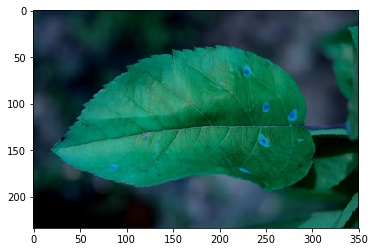

In [4]:
print(plt.imshow(train_X[0]))

In [5]:
gc.collect()

cv2.destroyAllWindows()
train_X = np.array(train_X)
training_y = []
for i in train_y:
    training_y.append((np.where(i==1)[0][0]))
training_y = np.array(training_y)    
    


In [6]:
gc.collect()

training_X = train_X[0:1120]
train_y = training_y [0:1120]
test_X = train_X[1120:1821]
test_Y = training_y[1120:1821]


In [7]:
gc.collect()

train_datagen = ImageDataGenerator(
#     rescale=1. / 255,
    rotation_range=360,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),
   tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(234,350,3)),
#     efn.EfficientNetB7(weights='imagenet', include_top=False, input_shape=(300,300,3)),
    
#     tf.keras.layers.Conv2D(128, (3, 3),activation='relu'),
#     tf.keras.layers.MaxPooling2D(3, 3),
#     tf.keras.layers.Flatten(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
 
    tf.keras.layers.Dense(512,activation = tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512,activation = tf.nn.relu,kernel_regularizer = tf.keras.regularizers.l2()),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4,activation = tf.nn.softmax)
])

model.compile(optimizer = tf.keras.optimizers.Adamax(),
          loss = 'categorical_crossentropy',
#             loss = tf.keras.losses.CategoricalHinge(),
          metrics=['accuracy'])




#--------------------------------------------------------------------------------#
# train_datagen = ImageDataGenerator(
#     rotation_range=360,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest')

# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(170,256,3)),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation = 'relu'),
#     tf.keras.layers.Dense(4,activation = tf.nn.softmax)
# ])

# model.compile(optimizer = tf.keras.optimizers.RMSprop(),
#           loss = 'categorical_crossentropy',
#           metrics=['accuracy'])
#---------------------------------------------------------------------------------#

83689472/83683744 [==============================] - 1s 0us/step


In [8]:
y_binary = to_categorical(training_y)
y_binary_train = to_categorical(train_y)
y_binary_test = to_categorical(test_Y)


In [9]:
gc.collect()
annealer = ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-5)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999 and logs.get('val_loss')<0.3):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [10]:
gc.collect()
callbacks = myCallback()

history = model.fit_generator(train_datagen.flow(training_X, y_binary_train, batch_size= 32 ),
                              steps_per_epoch=len(training_X) / 32,
                              validation_data = (test_X, y_binary_test),
                              epochs=100,
                              callbacks=[annealer,callbacks],)

Train for 35.0 steps, validate on 701 samples
Epoch 1/100
35/35 [==============================] - 41s 1s/step - loss: 4.8762 - accuracy: 0.6464 - val_loss: 7.4609 - val_accuracy: 0.5934
Epoch 2/100
35/35 [==============================] - 31s 899ms/step - loss: 3.0635 - accuracy: 0.8929 - val_loss: 4.7134 - val_accuracy: 0.7290
Epoch 3/100
35/35 [==============================] - 31s 885ms/step - loss: 2.2694 - accuracy: 0.9312 - val_loss: 2.3317 - val_accuracy: 0.8887
Epoch 4/100
35/35 [==============================] - 31s 899ms/step - loss: 1.8054 - accuracy: 0.9527 - val_loss: 1.8295 - val_accuracy: 0.9130
Epoch 5/100
35/35 [==============================] - 31s 890ms/step - loss: 1.4790 - accuracy: 0.9589 - val_loss: 1.7265 - val_accuracy: 0.8959
Epoch 6/100
35/35 [==============================] - 31s 900ms/step - loss: 1.2442 - accuracy: 0.9580 - val_loss: 1.3457 - val_accuracy: 0.9315
Epoch 7/100
35/35 [==============================] - 31s 883ms/step - loss: 1.0716 - accuracy

In [11]:
model.evaluate(test_X, y_binary_test)

701/701 [==============================] - 3s 5ms/sample - loss: 0.2922 - accuracy: 0.9572


[0.29216827334206386, 0.957204]

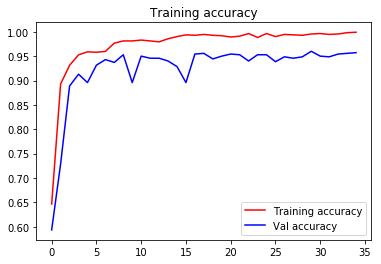

<Figure size 432x288 with 0 Axes>

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Val accuracy')
plt.title('Training accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

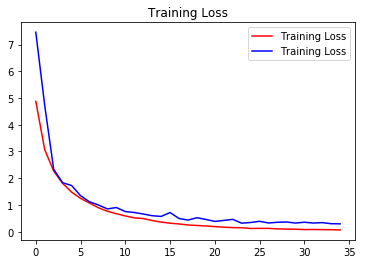

<Figure size 432x288 with 0 Axes>

In [13]:
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Training Loss')
plt.title('Training Loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [14]:
gc.collect()
test = []
for i in range(0,1821):
    image = (cv2.imread("/kaggle/input/plant-pathology-2020-fgvc7/images/Test_" + str(i) + ".jpg"))
    resized = cv2.resize(image, (350,234), interpolation = cv2.INTER_AREA)
    test.append(resized - [50,50,50])

In [15]:
gc.collect()
results = []
for i in test:
    result = model.predict(np.array([i]))
    results.append(result[0])

In [16]:

df = pd.DataFrame(results, columns = ['healthy', 'multiple_diseases','rust','scab']) 


In [17]:
image_id = []
for  i in range(0,1821):
    image_id.append("Test_"+str(i))


In [18]:
df.insert(0,"image_id",image_id,False)

In [19]:
df.to_csv('submission.csv', index=False)

In [20]:
df

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,4.374982e-06,9.534675e-06,9.999839e-01,2.169867e-06
1,Test_1,8.623869e-05,1.222419e-04,9.997360e-01,5.549360e-05
2,Test_2,3.463357e-09,1.340183e-08,1.910259e-09,1.000000e+00
3,Test_3,9.999896e-01,7.111093e-07,7.785346e-06,1.929925e-06
4,Test_4,2.025951e-05,4.586364e-05,9.999177e-01,1.614278e-05
...,...,...,...,...,...
1816,Test_1816,1.804026e-07,2.825228e-07,9.999994e-01,1.227255e-07
1817,Test_1817,4.421428e-04,6.015900e-04,2.325437e-04,9.987237e-01
1818,Test_1818,3.422286e-06,3.636351e-06,9.999911e-01,1.924500e-06
1819,Test_1819,9.997014e-01,6.986405e-05,1.771647e-04,5.158349e-05
